In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



Hyperparameters

In [5]:
###----------------
#Global Variables
###----------------

from calendar import EPOCH


TEST_SIZE = 0.2
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)


N_SAMPLES = 1000
NOISE = 0.2
ALPHA = 0.1
EPOCHS = 200

# set location of input files and output files
inpDir = '../input'
outDir = '../output'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

Load Data

In [6]:
X, y = datasets.make_moons(
    n_samples=N_SAMPLES,
    noise=NOISE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

X.shape, y.shape


((1000, 2), (1000,))

EDA

In [7]:
df = pd.DataFrame(X, columns=["X_1", "X_2"])
df["Target"] = y
df.head()

,X_1,X_2,Target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


<Figure size 1500x400 with 0 Axes>

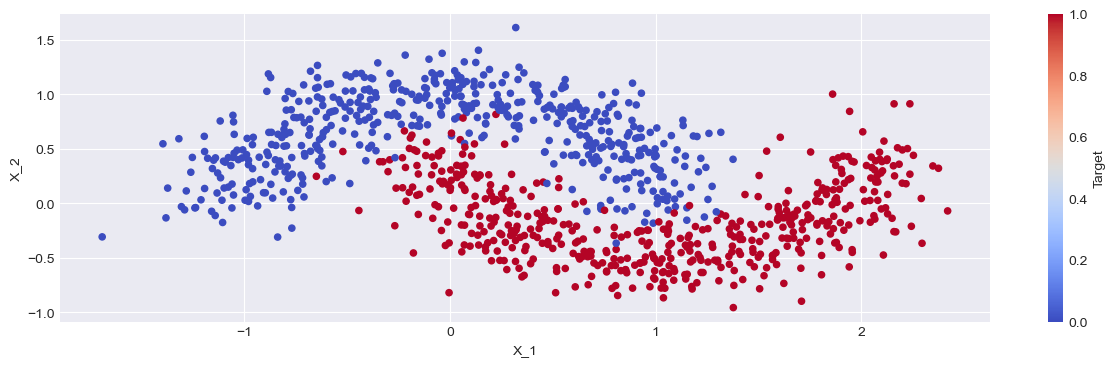

In [8]:
plt.figure()
df.plot.scatter(x="X_1", y="X_2", c="Target", cmap=CMAP)
plt.show() 

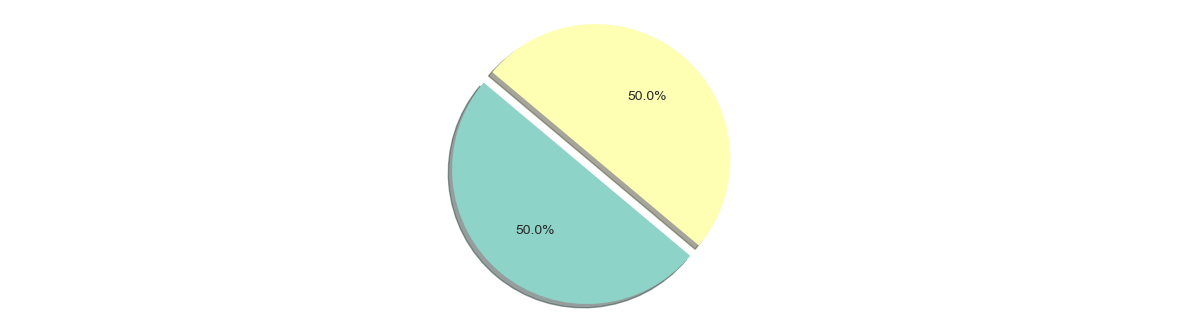

In [9]:
fix, axis = plt.subplots()
explode = (0, 0.1,) # only "explode" the 2nd ring
axis.pie(
    df['Target'].value_counts(), 
    explode=explode, 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=140
)
axis.axis('equal') 
plt.show()

In [10]:
data_train, data_text = df.to_numpy()[:9000], df.to_numpy()[9000:]

display(data_train.shape, data_text.shape)
display(type(data_train), type(data_text))

(1000, 3)

(0, 3)

numpy.ndarray

numpy.ndarray

In [11]:
def predict(row, wgts):
    """
    Make a prediction based on the given row and weights.
        
    z = wgts[0] + row[i] * wgts[i+1] + ... + row[n] * wgts[n+1]
            ^               ^                  ^ 
            bias        first weight        nth weight

    if z >= 0 then predict 1
    else predict 0

    Args:
        row (array): all the values in the row
        wgts (_type_): all the weights for perticular epoch 

    Returns:
        z (int): the prediction
    """

    z = wgts[0] # bias

    for i in range(len(row) - 1):
        z = z + row[i] * wgts[i + 1]

    return 1 if z >= 0 else 0



# Unit test
predict(
    df.loc[0].values,
    np.array([0.5, 0.3, 0.2])
)

1

In [12]:
# This will generate a random number
rng = np.random.default_rng(seed=RANDOM_STATE)


def train_weights(train, aplha, n_epochs):
    """
    The training function for the neural network without using any activation function
    
    ∂Loss(a,y)/∂z   = a - y       => ∂z = dz 
    ∂Loss(a,y)/∂w   = Xₙ(a - y)   => ∂w = dw

    Args:
        train (array): all the feature variables
        aplha (float): the learning rate    
        n_epochs (int): the number of epochs / iterations
    
    Returns:
        weights (array): the weights of the neural network
    """

    errors = []
    weights = rng.random(train.shape[1]) # Random initial weights
    m = train.shape[0] # Number of samples

    for epoch in range(n_epochs):
        sum_error = 0.0
        for row in train:
            prediction = predict(row, weights)

            dz = prediction - row[-1]
            
            sum_error += (prediction - row[-1])**2

            weights[0] += -aplha * dz/m

            for i in range(len(row)-1):
                weights[i+1] += -aplha * dz * row[i]/m      # wᵢ = wᵢ + α(y − ŷ)*xᵢ
        
        errors.append(sum_error/m)
        # print(f"Epoch {epoch+1} Error: {sum_error/m}")
        
    return errors, weights

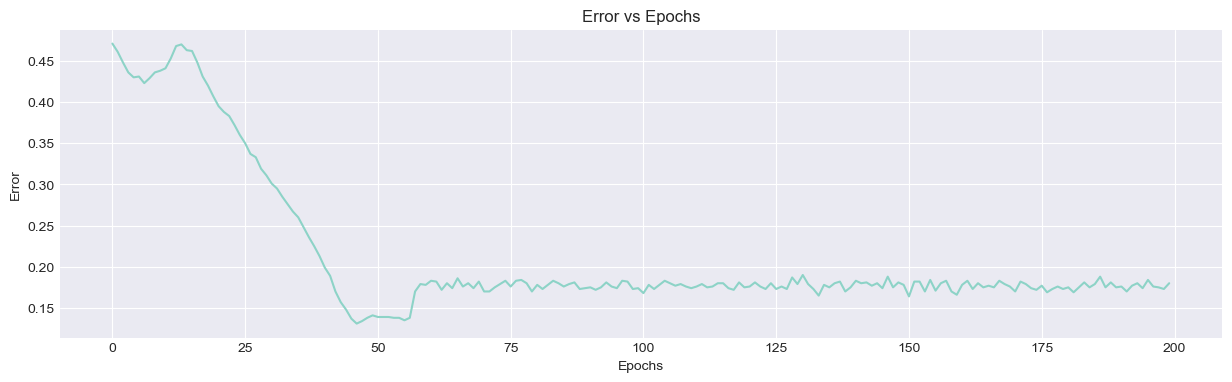

In [13]:
errors, weights = train_weights(data_train,ALPHA,EPOCHS)

fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel('Epochs')
ax.set_ylabel('Error')
ax.set_title('Error vs Epochs')
plt.show()
 

(26, 42)

(26, 42)

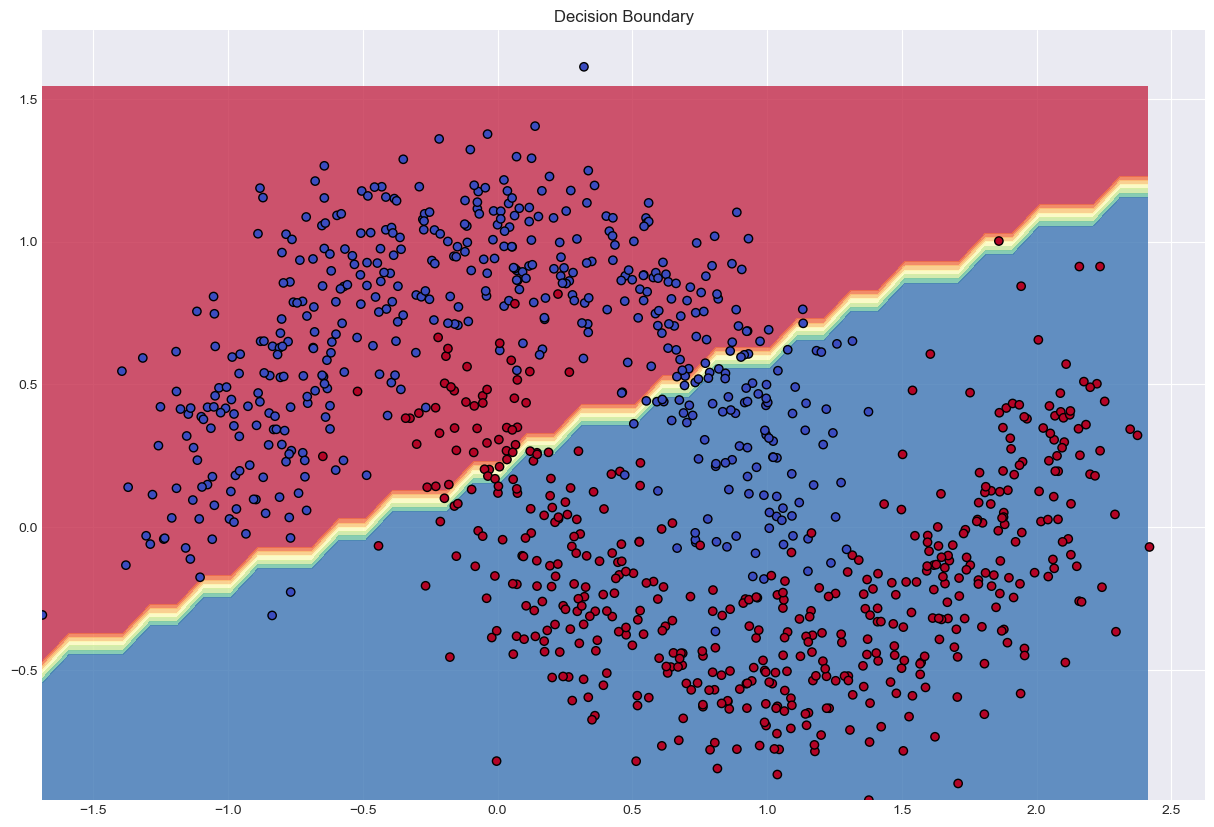

In [25]:
def plot_decision_boundary(wts, X):
    dm = 0.1

    # Minimum and maximum values along each axis
    x_min, x_max = X[:, 0].min(), X[:, 0].max() 
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    # Generate a grid of points with distance 'dm' using min and max values alogn each axis
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, dm), 
        np.arange(y_min, y_max, dm)
    )

    display(xx.shape, yy.shape)

    XX = np.c_[
        xx.ravel(),
        yy.ravel()
    ]

    XX = np.hstack((
        XX,
        np.ones((XX.shape[0], 1))
    ))

    y_pred = []

    for row in XX:
        y_p = predict(row, wts)
        y_pred.append(y_p)

    Z = np.array(y_pred).reshape(xx.shape)


    fig, ax = plt.subplots(figsize=(15, 10))
    ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.8)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2], cmap=CMAP, edgecolors='k')
    ax.set_title('Decision Boundary')
    plt.show()


plot_decision_boundary(weights, data_train)
